In [ ]:
%%writefile descents.py
import numpy as np
from abc import ABC, abstractmethod

# ===== Learning Rate Schedules =====
class LearningRateSchedule(ABC):
    @abstractmethod
    def get_lr(self, iteration: int) -> float:
        pass


class ConstantLR(LearningRateSchedule):
    def __init__(self, lr: float):
        self.lr = lr

    def get_lr(self, iteration: int) -> float:
        return self.lr


class TimeDecayLR(LearningRateSchedule):
    def __init__(self, lambda_: float = 1.0):
        self.s0 = 1
        self.p = 0.5
        self.lambda_ = lambda_

    def get_lr(self, iteration: int) -> float:
        return self.lambda_ * (self.s0 / (self.s0 + iteration)) ** self.p


# ===== Base Optimizer =====
class BaseDescent(ABC):
    def __init__(self, lr_schedule: LearningRateSchedule = TimeDecayLR):
        self.lr_schedule = lr_schedule()
        self.iteration = 0
        self.model = None

    def set_model(self, model):
        self.model = model

    @abstractmethod
    def update_weights(self):
        pass

    def step(self):
        self.update_weights()
        self.iteration += 1


# ===== Specific Optimizers =====
class VanillaGradientDescent(BaseDescent):
    def __init__(self, lr_schedule: LearningRateSchedule = TimeDecayLR):
        super().__init__(lr_schedule)
    def update_weights(self):
        lr = self.lr_schedule.get_lr(self.iteration)
        X = self.model.X_train
        y = self.model.y_train
        gradient = self.model.compute_gradients(X, y)
        weight_diff = -lr * gradient
        if self.model.w is None:
            self.model.w = np.zeros(X.shape[1])
        self.model.w = self.model.w + weight_diff
        return weight_diff


class StochasticGradientDescent(BaseDescent):
    def __init__(self, lr_schedule: LearningRateSchedule = TimeDecayLR, batch_size=64):
        super().__init__(lr_schedule)
        self.batch_size = batch_size

    def update_weights(self):
        lr = self.lr_schedule.get_lr(self.iteration)
        X = self.model.X_train
        y = self.model.y_train
        n = len(X)
        batch_i = np.random.randint(0, n, self.batch_size)
        X_b = X[batch_i]
        y_b = y[batch_i]
        gradient = self.model.compute_gradients(X_b, y_b)
        weight_diff = -lr * gradient
        if self.model.w is None:
            self.model.w = np.zeros(X.shape[1])
        self.model.w = self.model.w + weight_diff
        return weight_diff


class SAGDescent(BaseDescent):
    def __init__(self, lr_schedule: LearningRateSchedule = TimeDecayLR):
        super().__init__(lr_schedule)
        self.grad_memory = None
        self.grad_sum = None

    def update_weights(self):
        lr = self.lr_schedule.get_lr(self.iteration)
        X_train = self.model.X_train
        y_train = self.model.y_train
        num_objects, num_features = X_train.shape
        if self.grad_memory is None:
            self.grad_memory = np.zeros((num_objects, num_features))
            self.grad_sum = np.zeros(num_features)
        j = np.random.randint(0, num_objects)
        X_j = X_train[j:j+1]
        y_j = y_train[j:j+1]
        grad_jnew = self.model.compute_gradients(X_j, y_j)
        grad_jold = self.grad_memory[j]
        self.grad_sum += grad_jnew - grad_jold
        self.grad_memory[j] = grad_jnew
        weight_diff = -lr * self.grad_sum / num_objects
        if self.model.w is None:
            self.model.w = np.zeros(num_features)
        self.model.w = self.model.w + weight_diff
        return weight_diff

class MomentumDescent(BaseDescent):
    def __init__(self, lr_schedule: LearningRateSchedule = TimeDecayLR, beta=0.9):
        super().__init__(lr_schedule)
        self.beta = beta
        self.velocity = None

    def update_weights(self):
        lr = self.lr_schedule.get_lr(self.iteration)
        X = self.model.X_train
        y = self.model.y_train
        gradient = self.model.compute_gradients(X, y)
        if self.velocity is None:
            self.velocity = np.zeros_like(gradient)
        self.velocity = self.beta * self.velocity + lr * gradient
        weight_diff = -self.velocity
        if self.model.w is None:
            self.model.w = np.zeros(X.shape[1])
        self.model.w = self.model.w + weight_diff
        return weight_diff


class Adam(BaseDescent):
    def __init__(self, lr_schedule: LearningRateSchedule = TimeDecayLR, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(lr_schedule)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = None
        self.v = None

    def update_weights(self):
        lr = self.lr_schedule.get_lr(self.iteration)
        X = self.model.X_train
        y = self.model.y_train
        gradient = self.model.compute_gradients(X, y)
        if self.m is None:
            self.m = np.zeros_like(gradient)
            self.v = np.zeros_like(gradient)
        self.m = self.beta1 * self.m + (1 - self.beta1) * gradient
        self.v = self.beta2 * self.v + (1 - self.beta2) * (gradient ** 2)
        m_h = self.m / (1 - self.beta1 ** (self.iteration + 1))
        v_h = self.v / (1 - self.beta2 ** (self.iteration + 1))
        weight_diff = -lr * m_h / (np.sqrt(v_h) + self.eps)
        if self.model.w is None:
            self.model.w = np.zeros(X.shape[1])
        self.model.w = self.model.w + weight_diff
        return weight_diff

Writing descents.py


In [ ]:
%%writefile linear_regression.py
import numpy as np
from descents import BaseDescent
from dataclasses import dataclass
from enum import auto, Enum
from typing import Dict, Type, Optional
from scipy.sparse.linalg import svds

class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()

class LinearRegression:
    def __init__(
        self,
        optimizer: Optional[BaseDescent | str] = None,
        l2_coef: float = 0.0,
        tolerance: float = 1e-6,
        max_iter: int = 1000,
        loss_function: LossFunction = LossFunction.MSE
    ):
        self.optimizer = optimizer
        if isinstance(optimizer, BaseDescent):
            self.optimizer.set_model(self)
        self.l2_coef = l2_coef
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.loss_function = loss_function
        self.w = None
        self.X_train = None
        self.y_train = None
        self.loss_history = []

    def predict(self, X: np.ndarray) -> np.ndarray:
        return X @ self.w
    def compute_gradients(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        if self.loss_function is LossFunction.MSE:
            n = len(X)
            predictions = X @ self.w
            return (2 / n) * X.T @ (predictions - y)
        # elif self.loss_function is ...
        return None

    def compute_loss(self, X: np.ndarray, y: np.ndarray) -> float:
        if self.loss_function is LossFunction.MSE:
            n = len(X)
            predictions = X @ self.w
            return np.mean((predictions - y) ** 2)
        # elif self.loss_function is ...
        return 0.0

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.X_train, self.y_train = X, y
        if self.w is None:
            self.w = np.zeros(X.shape[1])
        self.loss_history = []
        if self.optimizer is None:
            self.w = np.linalg.pinv(X.T @ X) @ X.T @ y
            self.loss_history = [self.compute_loss(X, y)]
            return

        elif self.optimizer == 'SVD':
            U, sigm, Vt = svds(X, k=4)
            S_inv = np.diag(1.0 / sigm)
            X_pinv = Vt.T @ S_inv @ U.T
            self.w = X_pinv @ y
            self.loss_history = [self.compute_loss(X, y)]
            return
        elif isinstance(self.optimizer, BaseDescent):
            initloss = self.compute_loss(X, y)
            self.loss_history.append(initloss)
            for i in range(self.max_iter):
                w_old = self.w.copy()
                self.optimizer.step()
                weight_diff = self.w - w_old
                diff_norm = np.sum(weight_diff ** 2)
                if diff_norm < self.tolerance:
                    break
                if np.any(np.isnan(self.w)):
                    break
                currloss = self.compute_loss(X, y)
                self.loss_history.append(currloss)
        else:
            raise NotImplementedError("Linear Regression training is not implemented")
        # elif self.optimizer is ... (для аналитического решения и SVD)

Writing linear_regression.py


# Машинное обучение, ФКН ВШЭ

## Практическое домашнее задание 2. Градиентный спуск своими руками

### Общая информация

Дата выдачи: 30.09.2025

Мягкий дедлайн: 14.10.2025 23:59

Жесткий дедлайн: 18.10.2025 23:59


### О задании

В данном задании необходимо реализовать обучение линейной регрессии с помощью различных модификаций градиентного спуска. В файле `descents.py` вам нужно будет реализовать несколько классов для различных вариаций градиентного спуска, а именно:
* `VanillaGradientDescent`
* `StochasticGradientDescent`
* `StochasticAverageGradient`
* `MomentumDescent`
* `Adam`

В файле `linear_regression.py` вам необходимо будет реализовать класс `LinearRegression` для обучения линейной регрессии (и, разумеется, предсказания целевой переменной на основе обученной модели).

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 11 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо считываемые диаграммы.

Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате **homework-practice-02-gd-Username.ipynb**, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: ...

## Задание 1. Реализация градиентного спуска (4 балла)

В этом задании вам предстоит написать собственные реализации различных подходов к градиентному спуску с опорой на подготовленные шаблоны в файле `descents.py`.

**Все реализуемые методы должны быть векторизованы!**

### Напоминание про градиентный спуск

Основное свойство антиградиента &ndash; он указывает в сторону *наискорейшего* убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента,
пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (например, нулевой или сгенерированный из некоторого
случайного распределения). Тогда ванильный градиентный спуск состоит в повторении следующих шагов до сходимости:

$$
    w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

Здесь $\eta_{k}$ обозначает длину шага на $k$-ой итерации (learning rate), а $Q(w)$ - функцию потерь (loss function).

### Градиент функции потерь MSE

На семинаре про [матрично-векторное дифференцирование](https://github.com/esokolov/ml-course-hse/blob/master/2025-fall/seminars/sem03-vector-diff.pdf) вы должны были обсуждать дифференцирование функции потерь MSE в матричном виде.

### Задание 1.0. Градиент MSE в матричном виде (0.02 балла).

Напомним, что функция потерь MSE записывается как:

$$
    Q(w) = \frac{1}{\ell} \sum \limits_{i = 1}^\ell (y_i - \langle x_i, w \rangle)^2 = \frac{1}{\ell} \| X w - y \|^2
$$

где $\ell$ – количество объектов в выборке, $X \in \mathbb{R}^{\ell \times d}$ – матрица "объект-признак", а $y \in \mathbb{R}^\ell$ – целевая переменная. Через $x_i$ обозначается $i$-ая строчка матрицы $X$, отвечающая за $i$-й объект выборки.

Выпишите ниже (подсмотрев в семинар или решив самостоятельно) градиент для функции потерь MSE в матричном виде.

**Решение:**


$$\nabla Q(w) = \frac{2}{l} X^T(Xw - y)$$

### Задание 1.1. Learning Rate Schedules (0.03 балла)

Обратите внимание на **абстрактный** класс `LearningRateSchedule` в файле `descents.py`. С помощью него мы на каждой итерации градиентного спуска будем получать соответствующий `learning_rate` $\eta_k$.

В файле уже реализован класс `ConstantLR`, который на каждой итерации возвращает один и тот же заранее заданный шаг. Ваша задача в этом пункте – реализовать `TimeDecayLR`, который мы будем использовать для обучения линейной регрессии. Формула очередного шага должна выглядеть следующим образом:
$$
    \eta_{k} = \lambda \left(\dfrac{s_0}{s_0 + k}\right)^p
$$

На практике достаточно настроить параметр $\lambda$, а остальным выставить параметры по умолчанию: $s_0 = 1, \, p = 0.5.$

**Обратите внимание**

Все реализуемые вами классы спуска в задании - это *универсальные* оптимизаторы. Они не должны считать градиенты конкретной функции потерь внутри себя.

Для вычисления градиента они всегда обращаются к модели, с которой работают:

```
gradient = self.model.compute_gradients(X_batch, y_batch)
```

Чтобы это работало, уже на данном этапе должны быть реализованы в `linear_regression.py`:

* `compute_gradients(X, y)` для MSE (в дальнейшем, в Задании 7, сюда добавляется член L2-регуляризации),
* `compute_loss(X, y)` для MSE (аналогично с учётом L2 при необходимости).

Если идёте строго по порядку, реализуйте эти MSE-версии в начале Задания 2.1 (используя формулы из п. 1.0), а затем вернитесь к заданиям 1.2–1.6 - код оптимизаторов менять не придётся. В Задании 8 вы просто расширите обе функции под `LogCosh` и `Huber`, переключая их через `self.loss_function`.

Такой подход позволяет свободно менять функцию потерь, не переписывая алгоритмы оптимизации.

### Задание-примечание 1.1. Родительский класс BaseDescent (0 баллов).

В файле `descents.py` приведен шаблон класса `BaseDescent` – родительского класса для модификаций градиентного спуска, от которого будут наследоваться другие классы (`VanillaGradientDescent`, `StochasticGradientDescent`, `MomentumDescent` и `Adam`). Более подробно про наследование классов в Python можно прочитать
* Наследование: https://docs.python.org/3/tutorial/classes.html#inheritance
* Абстрактные классы: https://docs.python.org/3/library/abc.html

В классе `BaseDescent` **все методы уже реализованы**. Цель этого задания – внимательно ознакомиться с тем, как устроен этот класс.

Обратите внимание на атрибут `self.iteration`, отвечающий за номер итерации алгоритма спуска. Как раз с помощью него (и `self.lr_schedule`) мы и будем получать `learning_rate` на соответствующей итерации алгоритма. Функция `update_weights` должна обновлять веса модели `self.model.w`, а также возвращать величину обновления $w_{k + 1} - w_k$

### Задание 1.2. Полный градиентный спуск VanillaGradientDescent (0.5 балла).

Реализуйте полный градиентный спуск заполнив пропуски в классе `VanillaGradientDescent` в файле `descents.py`. Напомним, что шаг классического градиентного спуска выглядит следующим образом:

$$
    w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

**Важно**: Здесь и далее функция `update_weights` должна возвращать разницу между $w_{k + 1}$ и $w_{k}$: $\quad w_{k + 1} - w_{k} = -\eta_{k} \nabla_{w} Q(w_{k})$. Кроме того, соответственно своему названию, она должна обновлять веса модели `model.w`.

### Напоминание про SGD (стохастических градиентный спуск)

Как правило, в задачах машинного обучения функционал $Q(w)$ представим в виде суммы $\ell$ функций:

$$
    Q(w)
    =
    \frac{1}{\ell}
    \sum_{i = 1}^{\ell}
        q_i(w).
$$

В нашем домашнем задании отдельные функции $q_i(w)$ соответствуют ошибкам на отдельных объектах.

Проблема метода градиентного спуска состоит в том, что на каждом шаге необходимо вычислять градиент всей суммы (будем его называть полным градиентом):

$$
    \nabla_w Q(w)
    =
    \frac{1}{\ell}
    \sum_{i = 1}^{\ell}
        \nabla_w q_i(w).
$$

Это может быть очень трудоёмко при больших размерах выборки. В то же время точное вычисление градиента может быть не так уж необходимо &ndash; как правило, мы делаем не очень большие шаги в сторону антиградиента, и наличие в нём неточностей не должно сильно сказаться на общей траектории.

Оценить градиент суммы функций можно средним градиентов случайно взятого подмножества функций:

$$
    \nabla_{w} Q(w_{k}) \approx \dfrac{1}{|B|}\sum\limits_{i \in B}\nabla_{w} q_{i}(w_{k}),
$$
где $B$ - это случайно выбранное подмножество индексов, обычно называемое **батчом**.

Оценка $\frac{1}{|B|} \sum \limits_{i \in B} \nabla_w q_i(w_k)$ называется **стохастическим градиентом** функции потерь, а получившийся метод называют методом **стохастического градиентного спуска** или просто SGD.

### Задание 1.3. Стохастический градиентный спуск StochasticGradientDescent (0.7 баллов).

Реализуйте стохастический градиентный спуск, заполнив пропуски в классе `StochasticGradientDescent`. Для оценки градиента используйте формулу выше (среднее градиентов случайно выбранного батча объектов). Шаг оптимизации:

$$
    w_{k + 1} = w_{k} - \eta_{k} \dfrac{1}{|B|}\sum\limits_{i \in B}\nabla_{w} q_{i}(w_{k}).
$$

Размер батча будет являться **гиперпараметром** метода и передаваться в конструктор класса `__init__(...)`. Семплировать индексы батча объектов $B$ можно с повторениями (через np.random.randint) - это допустимо и даёт несмещённую оценку градиента. По желанию можно без повторений (np.random.choice(..., replace=False) или через пермутацию по эпохам).

### Напоминание про метод инерции (или метод моментов)

Может оказаться, что направление антиградиента сильно меняется от шага к шагу. Например, если линии уровня функционала сильно вытянуты, то из-за ортогональности градиента линиям уровня он будет менять направление на почти противоположное на каждом шаге. Такие осцилляции будут вносить сильный шум в движение, и процесс оптимизации займёт много итераций. Чтобы избежать этого, можно усреднять векторы антиградиента с нескольких предыдущих шагов &ndash; в этом случае шум уменьшится, и такой средний вектор будет указывать в сторону общего направления движения. Введём для этого вектор инерции:

\begin{align}
    &h_0 = 0, \\
    &h_{k + 1} = \alpha h_{k} + \eta_k \nabla_w Q(w_{k})
\end{align}

Здесь $\alpha$ &ndash; параметр метода, определяющей скорость затухания градиентов с предыдущих шагов. Разумеется, вместо вектора градиента может быть использована его аппроксимация (например, в случае **стохастического градиентного спуска**). Чтобы сделать шаг градиентного спуска, просто сдвинем предыдущую точку на вектор инерции:

$$
    w_{k + 1} = w_{k} - h_{k + 1}.
$$

Заметим, что если по какой-то координате градиент постоянно меняет знак, то в результате усреднения градиентов в векторе инерции эта координата окажется близкой к нулю. Если же по координате знак градиента всегда одинаковый, то величина соответствующей координаты в векторе инерции будет большой, и мы будем делать большие шаги в соответствующем направлении.

### Задание 1.4 Stochastic Average Gradient (0.45 балла)

Держим память последних индивидуальных градиентов $g_i$ по всем объектам и их среднее $\bar g = \frac{1}{\ell}\sum_i g_i$. На каждом шаге выбираем индекс(ы) $j$ (мини-батч), заново считаем $g_j^{new}(w_k)$, обновляем среднее:
$$
\bar g \leftarrow \bar g + \frac{1}{\ell}\bigl(g_j^{new} - g_j^{old}\bigr),\qquad
w_{k+1} = w_k - \eta_k, \bar g.
$$
Инициализация: $g_i=0 \Rightarrow \bar g=0$.

Так получаем шаг почти как у полного градиента, но считаем градиент лишь на одном (или нескольких) объекте за итерацию.

Реализуйте класс `SAG` в `descents.py` с хранением `grad_memory` и `avg_grad`. Подсказка: чтобы получить пер-объектный градиент, можно вызывать `compute_gradients` на срезе из одного объекта `X[j:j+1]`.


### Задание 1.5 Метод Momentum - MomentumDescent (0.8 баллов).

Реализуйте градиентный спуск с методом инерции заполнив пропуски в классе `MomentumDescent`. Шаг оптимизации:

\begin{align}
    &h_0 = 0, \\
    &h_{k + 1} = \alpha h_{k} + \eta_k \nabla_w Q(w_{k}) \\
    &w_{k + 1} = w_{k} - h_{k + 1}.
\end{align}

$\alpha$ являеться гиперпараметром метода, однако в данном домашнем задании мы зафиксируем её за вас $\alpha = 0.9$.

### Напоминание про AdaGrad, RMSprop и Adam

Градиентный спуск очень чувствителен к выбору длины шага. Если шаг большой, то есть риск, что мы будем перескакивать через точку минимума; если же шаг маленький, то для нахождения минимума потребуется много итераций. При этом нет способов заранее определить правильный размер шага &ndash; к тому же, схемы с постепенным уменьшением шага по мере итераций могут тоже плохо работать.

В методе AdaGrad предлагается сделать свою длину шага для каждой компоненты вектора параметров. Идея проста: мы будем "копить" сумму квадратов градиентов и делить очередной градиент на корень из этой суммы. Таким образом, обновление весов с большими градиентами будет тормозиться, а с маленькими наоборот получать большие шаги. Формула обновлени будет выглядить так:

\begin{align}
    &G_{kj} = G_{k-1,j} + (\nabla_w Q(w_{k - 1}))_j^2; \\
    &w_{jk} = w_{j,k-1} - \frac{\eta_t}{\sqrt{G_{kj}} + \varepsilon} (\nabla_w Q(w_{k - 1}))_j.
\end{align}

Здесь $\varepsilon$ небольшая константа, которая предотвращает деление на ноль.

В данном методе можно зафиксировать длину шага (например, $\eta_k = 0.01$) и не подбирать её в процессе обучения **(обратите внимание, что в данном домашнем задании длина шага не фиксируется)**. Отметим, что данный метод подходит для разреженных задач, в которых у каждого объекта большинство признаков равны нулю. Для признаков, у которых ненулевые значения встречаются редко, будут делаться большие шаги; если же какой-то признак часто является ненулевым, то шаги по нему будут небольшими.

У метода AdaGrad есть большой недостаток: переменная $G_{kj}$ монотонно растёт, из-за чего шаги становятся всё медленнее и могут остановиться ещё до того, как достигнут минимум функционала. Проблема решается в методе RMSprop, где используется экспоненциальное затухание градиентов:

$$
    G_{kj} = \alpha G_{k-1,j} + (1 - \alpha) (\nabla_w Q(w^{(k-1)}))_j^2.
$$

В этом случае размер шага по координате зависит в основном от того, насколько
быстро мы двигались по ней на последних итерациях.

Можно объединить идеи описанных выше методов: накапливать градиенты со всех прошлых шагов для
избежания осцилляций (метод инерции), а также делать адаптивную длину шага по каждому параметру (`RMSProp`). Таким образом, мы получим метод `Adam` с той лишь разницей, что в методе `Adam` дополнительно делается нормировка накопленных градиентов и квадратов градиентов для устранения смещения.

### Задание 1.6. Метод Adam (Adaptive Moment Estimation) (1.5 балла).

Реализуйте градиентный спуск с методом Adam, заполнив пропуски в классе `Adam`. Шаг оптимизации:

\begin{align}
    &m_0 = 0, \quad v_0 = 0; \\ \\
    &m_{k + 1} = \beta_1 m_k + (1 - \beta_1) \nabla_w Q(w_{k}); \\ \\
    &v_{k + 1} = \beta_2 v_k + (1 - \beta_2) \left(\nabla_w Q(w_{k})\right)^2; \\ \\
    &\widehat{m}_{k} = \dfrac{m_k}{1 - \beta_1^{k}}, \quad \widehat{v}_{k} = \dfrac{v_k}{1 - \beta_2^{k}}; \\ \\
    &w_{k + 1} = w_{k} - \dfrac{\eta_k}{\sqrt{\widehat{v}_{k + 1}} + \varepsilon} \widehat{m}_{k + 1}.
\end{align}

$\beta_1 = 0.9, \beta_2 = 0.999$ и $\varepsilon = 10^{-8}$ будут зафиксированы за вас.

## Задание 2. Линейная регресия (1 балл)

### Задание 2.1. Решение методом градиентного спуска (0.5 балла)

В этом задании вам предстоит написать свою реализацию линейной регресии, обучаемой с использованием градиентного спуска, с опорой на подготовленные шаблоны в файле `linear_regression.py` - **LinearRegressionModel**. По сути линейная регрессия будет оберткой, которая запускает обучение

Необходимо соблюдать следующие условия:

* Все вычисления должны быть векторизованы;
* Циклы средствами python допускаются только для итераций градиентного спуска;
* В качестве критерия останова необходимо использовать (одновременно):
    * Квадрат евклидовой нормы разности весов на двух соседних итерациях меньше `tolerance`;
    * Разность весов содержит наны;
    * Достижение максимального числа итераций `max_iter`.
* Будем считать, что все данные, которые поступают на вход имеют столбец единичек последним столбцом;
* Веса модели надо обновлять внутри функции `update_weights`, она неспроста так называется
* Чтобы проследить за сходимостью оптимизационного процесса будем использовать `loss_history`, в нём будем хранить значения функции потерь до каждого шага, начиная с нулевого (до первого шага по антиградиенту) и значение функции потерь после оптимизации.

### Задание 2.2. Аналитическое решение (0.5 балла)

Но, как мы помним из лекции, помимо решения при помощи градиентного спуска, для ряда функций потерь можно выписать в том числе аналитическое решение. Давайте сперва вспомним, как оно выглядит для MSE. Выведите оптимальную формулу для $w$, держа в памяти формулу MSE, и дополните класс `LinearRegression`

$$\text{MSE} = \| X w - y \|^2$$
$$ w = $$

**Вопрос**: Как мы помним, у аналитического решения есть минусы, какие кстати?

**Ответ**: Возможность необратимости матрицы

Тут мы ничего специально проверять в контесте не будем

In [ ]:
import numpy as np
from linear_regression import LinearRegression

num_objects = 100
dimension = 5

x = np.random.rand(num_objects, dimension)
y = np.random.rand(num_objects)

In [ ]:
from sklearn.metrics import mean_squared_error as mse
import sklearn

sklearn_linreg = sklearn.linear_model.LinearRegression(fit_intercept=False)
sklearn_linreg.fit(x, y)
print("Sklearn MSE", mse(sklearn_linreg.predict(x), y))

your_linreg = LinearRegression(optimizer=None)
your_linreg.fit(x, y)
print("Your MSE", mse(your_linreg.predict(x), y))

assert abs(mse(your_linreg.predict(x), y) - mse(sklearn_linreg.predict(x), y)) < 1e-12, "Не повезло, попробуйте еще раз"

Sklearn MSE 0.0891258571624135
Your MSE 0.0891258571624135


Давайте сделаем задание немного прикольнее и изменим одну из колонок. Как мы знаем, полная мультиколлинеарность запрещает нам пользоваться аналитическим решением, но `sklearn` по какой-то причине это обходит, хмм

In [ ]:
x[:, 3] = x[:, 2] + x[:, 4]

In [ ]:
sklearn_linreg = sklearn.linear_model.LinearRegression(fit_intercept=False)
sklearn_linreg.fit(x, y)
print("Sklearn MSE", mse(sklearn_linreg.predict(x), y))

your_linreg = LinearRegression(optimizer=None)
your_linreg.fit(x, y)

print("Your MSE", mse(your_linreg.predict(x), y))

Sklearn MSE 0.09243813222592534
Your MSE 0.09243813222592534


Ваша задача - понять, как можно сделать так, чтобы аналитическое решение работало всегда, вне зависимости от матрицы X. Как оказывается, это можно сделать, если воспользоваться SVD разложением, в нашем случае усеченным, чтобы было проще (это не то же самое, что обычный SVD, у него другие размерности матриц, смотрите ниже). Воспользуйтесь `scipy.sparse.linalg.svds` с числом компонент 4

Выведите формулу для w и снова дополните класс `LinearRegression`

$$\text{X} = \underset{n\times m}{\mathrm{U}} \ \underset{m\times m}{\mathrm{\Sigma}} \ \underset{m\times k}{\mathrm{V^T}}$$
$$ w = $$

In [ ]:
sklearn_linreg = sklearn.linear_model.LinearRegression(fit_intercept=False)
sklearn_linreg.fit(x, y)
print("Sklearn MSE", mse(sklearn_linreg.predict(x), y))

your_linreg = LinearRegression(optimizer="SVD")
your_linreg.fit(x, y)
print("Your MSE", mse(your_linreg.predict(x), y))

assert abs(mse(your_linreg.predict(x), y) - mse(sklearn_linreg.predict(x), y)) < 1e-12, "Не повезло, попробуйте еще раз"

Sklearn MSE 0.09243813222592534
Your MSE 0.09243813222592535


## Задание 3. Проверка кода (0 баллов)

Данная секция нужна для того, чтобы убедиться в правильности реализации методов спуска и класса `LinearRegression`. В начале мы сделаем небольшую локальную проверку на "адекватность" и "запускаемость" ваших моделей, после чего уже можно будет делать посылки в Яндекс Контест.

In [ ]:
%load_ext autoreload

ModuleNotFoundError: No module named 'imp'

In [ ]:
#%autoreload 2

from descents import (
    VanillaGradientDescent,
    StochasticGradientDescent,
    SAGDescent,
    MomentumDescent,
    Adam
)

In [ ]:
num_objects = 100
dimension = 5

x = np.random.rand(num_objects, dimension)
y = np.random.rand(num_objects)

Проверяем код на запускаемость.

In [ ]:
# Если вы реализовали не все методы спуска, то уберите лишние из списка ниже
descent_models = [
    VanillaGradientDescent,
    StochasticGradientDescent,
    SAGDescent,
    MomentumDescent,
    Adam
]

max_iter = 10
tolerance = 0
num_objects = 100
dimension = 5

for descent_model in descent_models:
    optimizer = descent_model()
    model = LinearRegression(
        optimizer=optimizer,
        tolerance=tolerance,
        max_iter=max_iter,
    )
    model.fit(x, y)
    assert len(model.loss_history) == max_iter + 1, "Loss history failed"
    y_pred = model.predict(x)
    assert y_pred.shape == y.shape, "Prediction shape does not match target variable"

Если ваше решение прошло все тесты локально, то теперь пришло время протестировать его в [Яндекс Контесте](https://new.contest.yandex.ru/contests/82854/start).

Для каждой задачи из контеста вставьте ID успешной посылки и ваш ник (почту):

* **Ник/почта**: ssshibaev23@yandex.ru


* **VanillaGradientDescent**: ID 145285233


* **StochasticDescent**: ID 145285241


* **SAGDescent**: ID 145285251


* **MomentumDescent**: ID 145285262


* **Adam**: ID 145285271


* **LinearRegression**: ID 145285368

## Задание 4. Работа с данными (1 балл)

Мы будем использовать датасет объявлений по продаже машин на немецком Ebay. В задаче предсказания целевой переменной для нас будет являться цена.

* Постройте график распределения целевой переменной в данных, подумайте, нужно ли заменить её на логарифм. Присутствуют ли выбросы в данных с аномальной ценой? Если да, то удалите их из данных.

* Проведите исследование данных:
    * Проанализируйте тип столбцов, постройте графики зависимости целевой переменной от признака, распределения значений признака;
    * Подумайте (и напишите): какие признаки могут быть полезными на основе этих графиков, обработайте выбросы;
    * Подумайте (и напишите): какие трансформации признаков из известных вам будет уместно применить;
    * Разделите полезные признаки на категориальные, вещественные и те, которые не надо предобрабатывать.
* Разделите данные на обучающую, валидационную и тестовую выборки в отношении 8:1:1.

In [ ]:
import numpy as np
import pandas as pd  # при желании, можете заменить на polars/pyspark или что угодно, что вам нравится

import matplotlib.pyplot as plt
import seaborn as sns

from descents import (
    ConstantLR, TimeDecayLR,
    VanillaGradientDescent, StochasticGradientDescent,
    MomentumDescent, Adam, SAGDescent
)
from linear_regression import LinearRegression

sns.set(style='darkgrid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

file_path = '/content/drive/MyDrive/autos.csv'
data = pd.read_csv(file_path)


Mounted at /content/drive


In [96]:
data.head()

,brand,model,vehicleType,gearbox,fuelType,notRepairedDamage,powerPS,kilometer,autoAgeMonths,price
0,volkswagen,golf,kleinwagen,manuell,benzin,nein,75,150000,177,1500
1,skoda,fabia,kleinwagen,manuell,diesel,nein,69,90000,93,3600
2,bmw,3er,limousine,manuell,benzin,ja,102,150000,246,650
3,peugeot,2_reihe,cabrio,manuell,benzin,nein,109,150000,140,2200
4,mazda,3_reihe,limousine,manuell,benzin,nein,105,150000,136,2000


Колонки в данных:

* `brand` - название бренда автомобиля
* `model` - название модели автомобиля
* `vehicleType` - тип транспортного средства
* `gearbox` - тип трансмисcии
* `fuelType` - какой вид топлива использует автомобиль
* `notRepairedDamage` - есть ли в автомобиле неисправность, которая еще не устранена
* `powerPS` - мощность автомобиля в PS (метрическая лошадиная сила)
* `kilometer` - сколько километров проехал автомобиль, пробег
* `autoAgeMonths` - возраст автомобиля в месяцах


* `price` - цена, указанная в объявлении о продаже автомобиля (целевая переменная)

In [132]:
df = data.copy()

Text(0, 0.5, 'Количество')

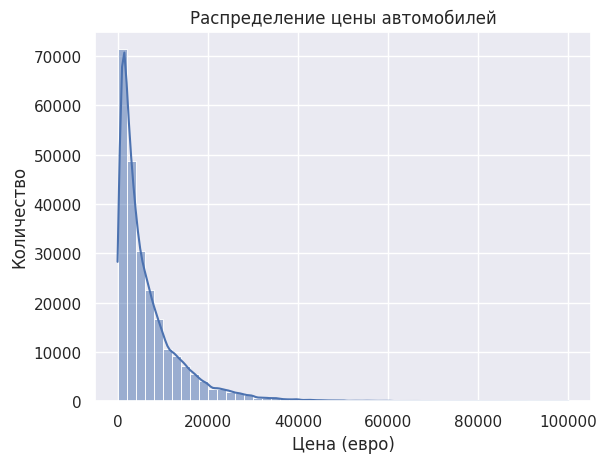

In [133]:
sns.histplot(df, x='price', bins=50, kde=True)
plt.title('Распределение цены автомобилей')
plt.xlabel('Цена (евро)')
plt.ylabel('Количество')

Text(0, 0.5, 'Количество')

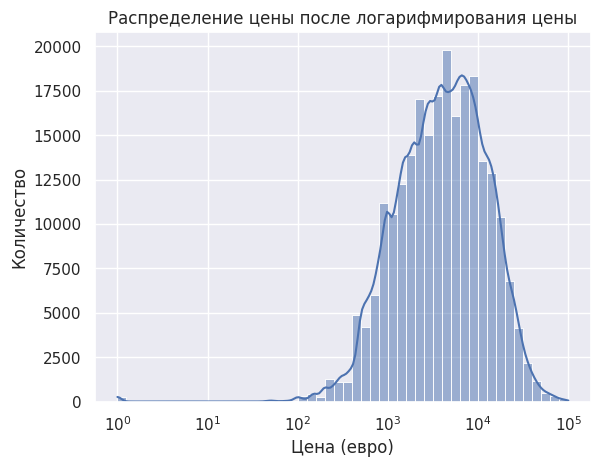

In [134]:
sns.histplot(df, x='price', bins=50, kde=True, log_scale=True)
plt.title('Распределение цены после логарифмирования цены')
plt.xlabel('Цена (евро)')
plt.ylabel('Количество')

Во-первых видим что логарифмировать цену стоит, так как первый график сильно скошен, дешевых машин много, дорогих мало
Во-вторых видим выбросы, удалим их

In [135]:
df = df.loc[data['price'] >= 100]
df['price'] = np.log(df['price'])

Text(0, 0.5, 'Количество')

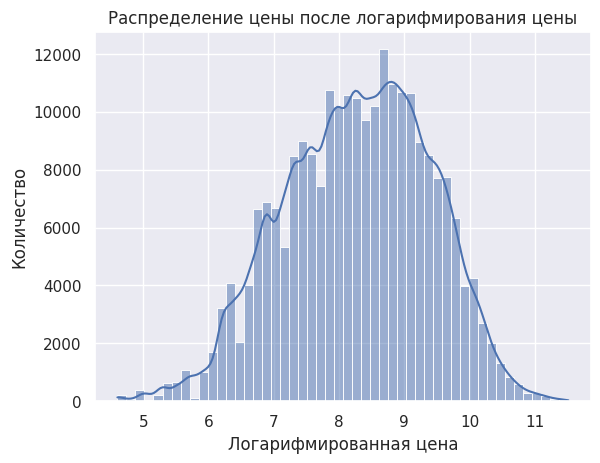

In [136]:
sns.histplot(df, x='price', bins=50, kde=True)
plt.title('Распределение цены после логарифмирования цены')
plt.xlabel('Логарифмированная цена')
plt.ylabel('Количество')

Разделите признаки на категориальные, числовые и ... все остальное

In [137]:
categorical = []
numeric = []
other = []
for c in df.columns:
    if c == 'price':
        continue

    dtype = df[c].dtype
    if dtype == 'object':
        categorical.append(c)
    elif np.issubdtype(dtype, np.number):
        numeric.append(c)
    else:
        other.append(c)

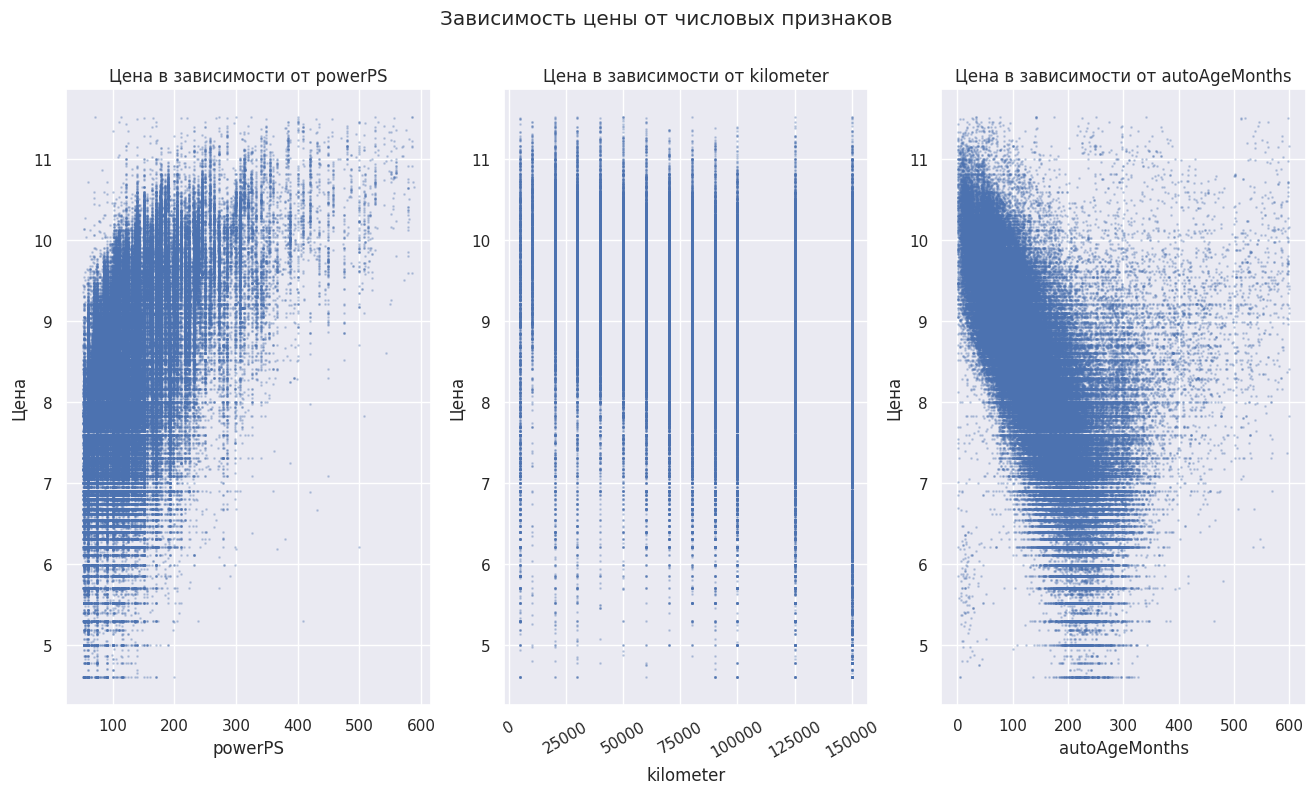

In [138]:
fig, ax = plt.subplots(1, len(numeric), figsize=(16, 8))
for i, col in enumerate(numeric):
    ax[i].scatter(df[col], df['price'], alpha=0.25, s=1)
    ax[i].set_title(f'Цена в зависимости от {col}')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Цена')
    fig.suptitle('Зависимость цены от числовых признаков')
ax[1].tick_params(axis='x', rotation=30)

График зависимости от километров показывает дискретную зависимость из-за округления. График зависимости от лошадиных сил и месяцев проката авто прямую и обратную соответственно

Text(0.5, 0.98, 'Распределения числовых признаков')

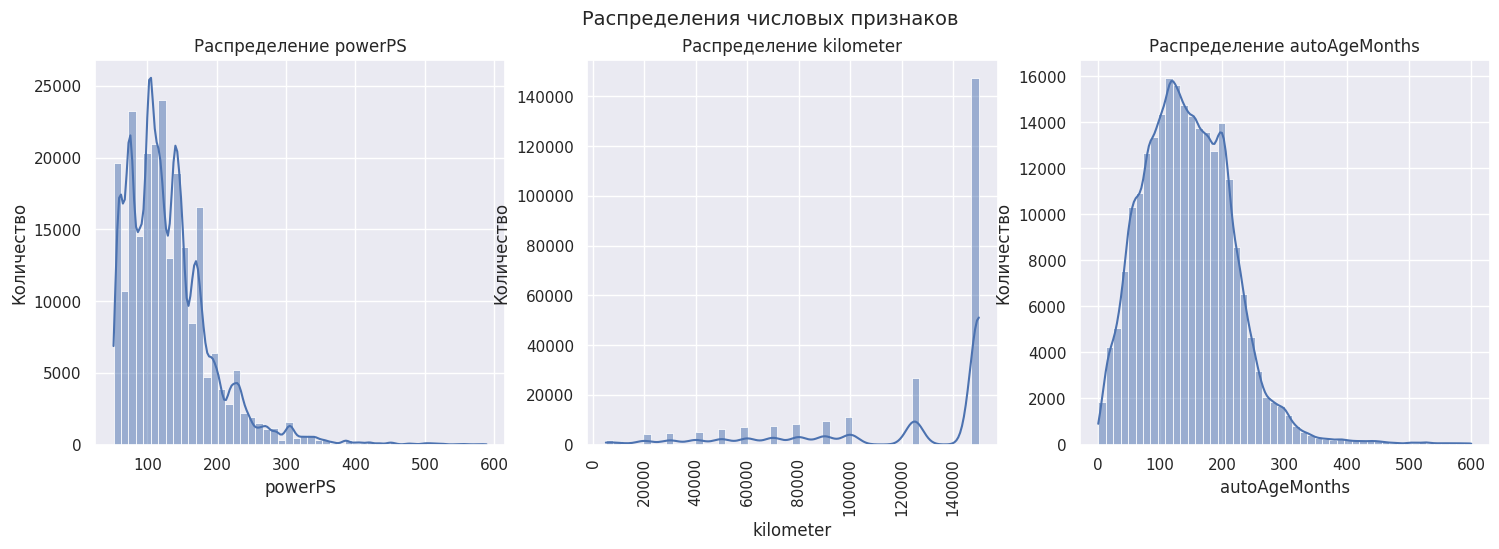

In [139]:
fig, ax = plt.subplots(1, len(numeric), figsize=(18, 5))
for i, col in enumerate(numeric):
    sns.histplot(df[col], bins=50, kde=True, ax=ax[i])
    ax[i].set_title(f'Распределение {col}', fontsize=12)
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Количество')
ax[1].tick_params(axis='x', rotation=90)
fig.suptitle('Распределения числовых признаков', fontsize=14)

увидели явные длинные хвосты на первом и третьем графике, почистим выбросы, но уберем справа больше значений тк графики скошены влево

In [140]:
for col in numeric:
    if col == 'kilometer':
      continue
    q1 = df[col].quantile(0.005)
    q2 = df[col].quantile(0.99)
    df = df[(df[col] >= q1) & (df[col] <= q2)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 234682 entries, 0 to 241189
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   brand              234682 non-null  object 
 1   model              234682 non-null  object 
 2   vehicleType        234682 non-null  object 
 3   gearbox            234682 non-null  object 
 4   fuelType           234682 non-null  object 
 5   notRepairedDamage  234682 non-null  object 
 6   powerPS            234682 non-null  int64  
 7   kilometer          234682 non-null  int64  
 8   autoAgeMonths      234682 non-null  int64  
 9   price              234682 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 19.7+ MB


Text(0.5, 0.98, 'Распределения числовых признаков')

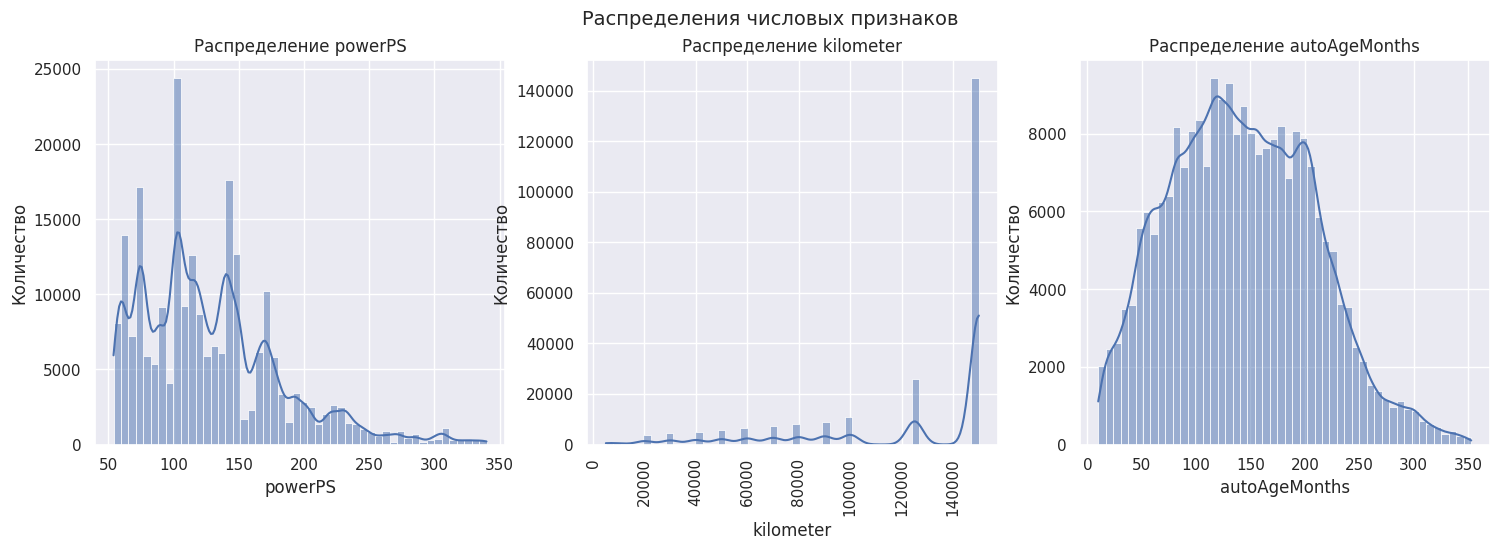

In [141]:
fig, ax = plt.subplots(1, len(numeric), figsize=(18, 5))
for i, col in enumerate(numeric):
    sns.histplot(df[col], bins=50, kde=True, ax=ax[i])
    ax[i].set_title(f'Распределение {col}', fontsize=12)
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Количество')
ax[1].tick_params(axis='x', rotation=90)
fig.suptitle('Распределения числовых признаков', fontsize=14)

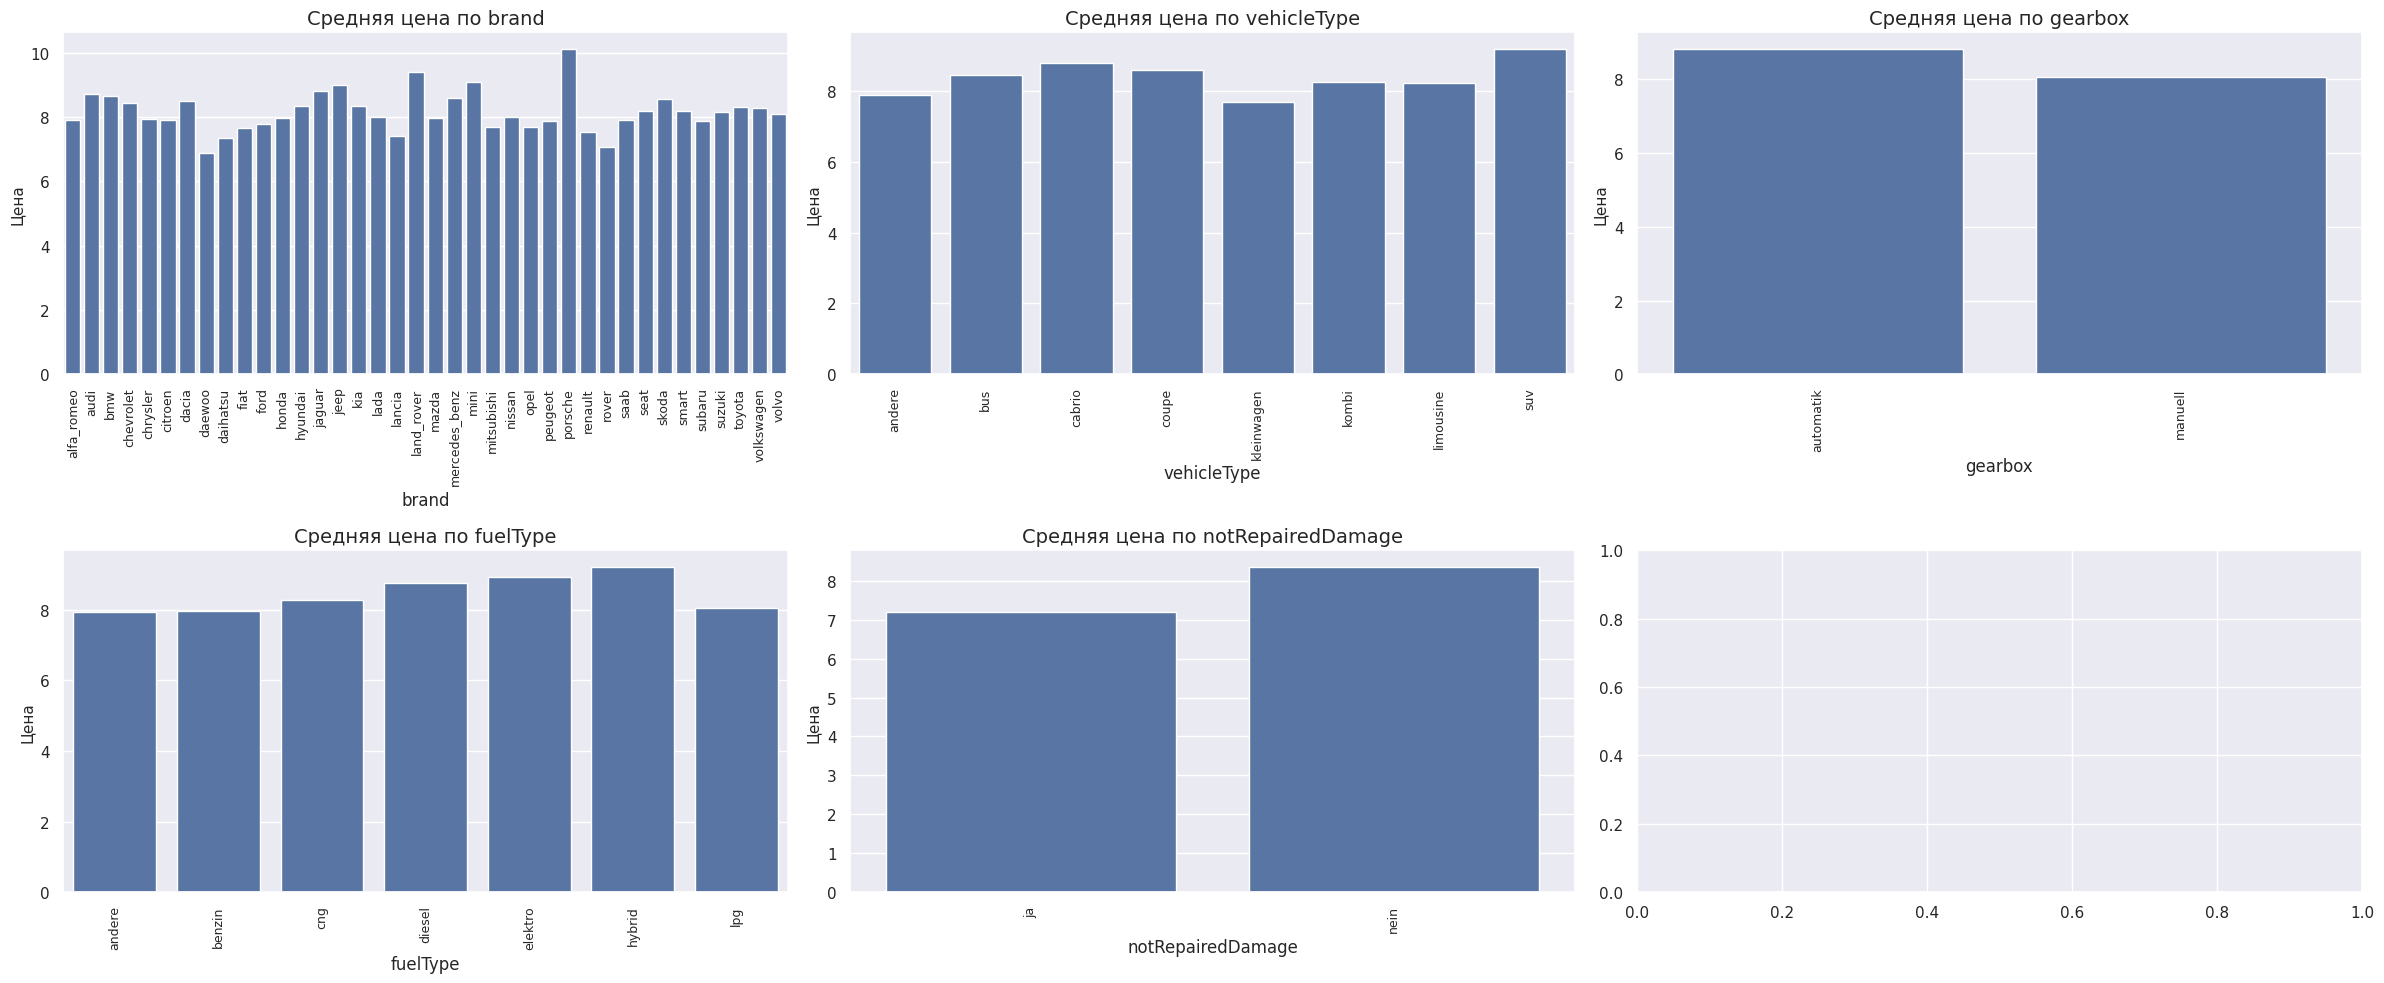

In [142]:
fig, ax = plt.subplots(2, 3, figsize=(24, 10))
ax = ax.flatten()
j = 0
categorical.remove('model')
for col in categorical:
    df_gr = df[[col, 'price']].groupby(col)['price'].mean().reset_index()
    sns.barplot(data=df_gr, x=col, y='price', ax=ax[j])
    ax[j].set_title(f'Средняя цена по {col}', fontsize=14)
    ax[j].set_xlabel(col)
    ax[j].set_ylabel('Цена', fontsize=11)
    ax[j].tick_params(axis='x', rotation=90, labelsize=9)
    j += 1

plt.tight_layout()


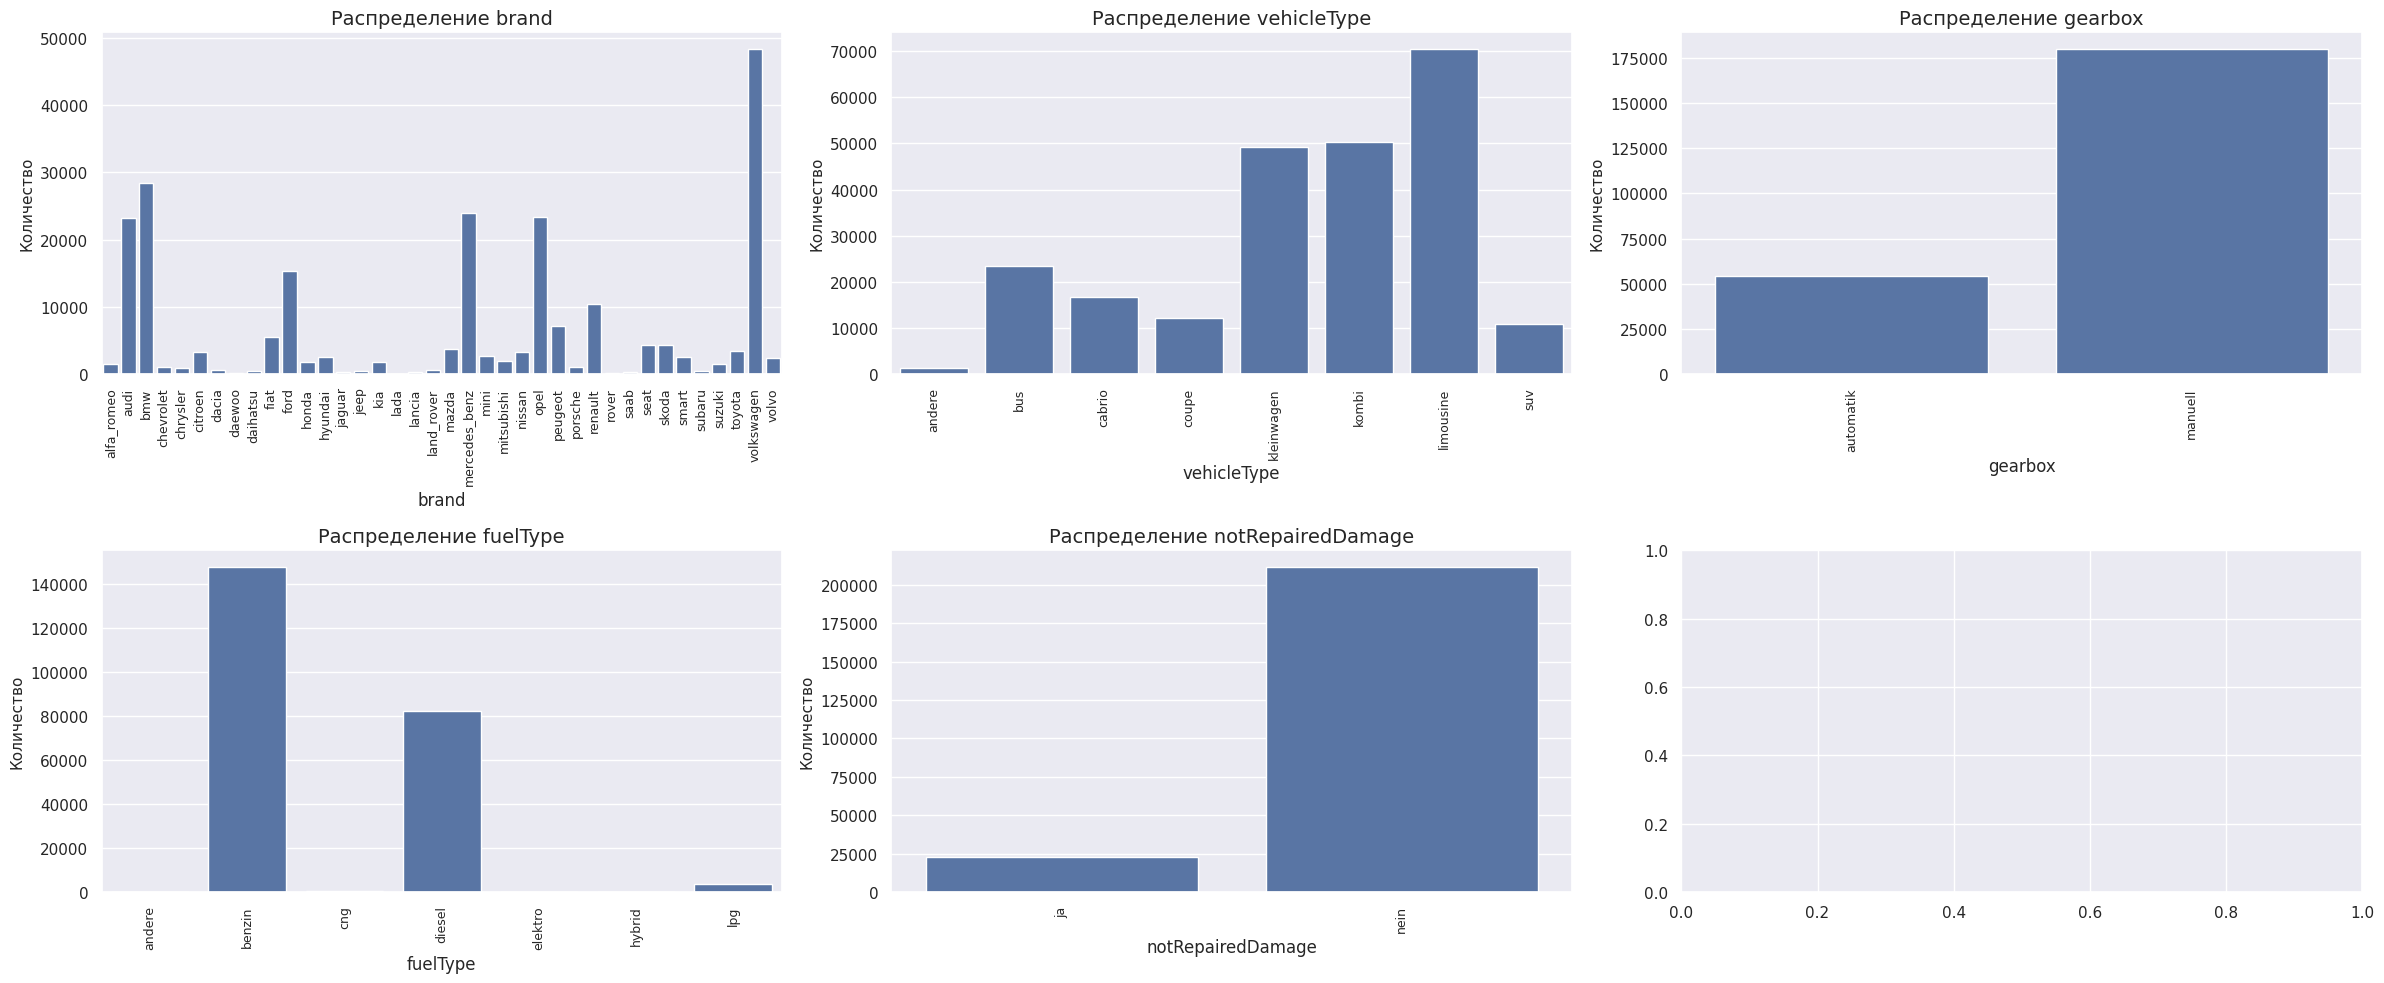

In [144]:
fig, ax = plt.subplots(2, 3, figsize=(24, 10))
ax = ax.flatten()

j = 0
for col in categorical:
    df_gr = df.groupby(col).size().reset_index(name='count')
    sns.barplot(data=df_gr, x=col, y='count', ax=ax[j])
    ax[j].set_title(f'Распределение {col}', fontsize=14)
    ax[j].set_xlabel(col)
    ax[j].set_ylabel('Количество', fontsize=11)
    ax[j].tick_params(axis='x', rotation=90, labelsize=9)
    j += 1
plt.tight_layout()

Не строил график в зависимости от модели потому что слишком много уникальных значений. Я бы этот признак убрал, тк вызовет переобучение.

Возможно стоило (уменьшить количество вариантов в признаках brand и fueltype тк большое количество категорий увеличит вероятность переобучения и повысит вычислительную сложность. Поделить топливо и бренды на три типа. Бренд делим в зависимости от медианной стоимости (берем не среднее тк у некоторых марок бывают редкие машины люкс-сегмента), топливо по смыслу + опираясь на среднюю цену по графику. ) но уже все более менее заработало без этого, времени мало, не стал портить, оставил как есть.

In [124]:
'''df.drop(columns = 'model', inplace = True)
def fuel(x):
    if not isinstance(x, str):
        return 'gasoline'
    x = x.lower().strip()
    if x == 'diesel':
        return 'diesel'
    elif x in ['elektro', 'hybrid']:
        return 'eco'
    elif x in ['benzin', 'cng', 'lpg', 'andere']:
        return 'gasoline'
    else:
        return 'gasoline'
df['fuelType'] = df['fuelType'].apply(fuel)
df['fuelType'].value_counts()'''


,count
fuelType,
gasoline,152112
diesel,82358
eco,212


In [125]:
'''brand_price = df.groupby('brand')['price'].median()
q1 = brand_price.quantile(0.2)
q2 = brand_price.quantile(0.4)
q3 = brand_price.quantile(0.6)
q4 = brand_price.quantile(0.8)
def brand_segment(brand):
    price = brand_price[brand]
    if price <= q1:
        return 'low'
    elif price <= q2:
        return 'low-mid'
    elif price <= q3:
        return 'mid'
    elif price <= q4:
        return 'high-mid'
    else:
        return 'high'
df['brand'] = df['brand'].apply(brand_segment)'''

Добавляем в данные единичную колонку `bias`, чтобы не делать отдельные параметр $b$ для свободного члена модели.

In [145]:
df['bias'] = 1
other += ['bias']
x = df[categorical + numeric + other]
y = df['price']
x

,brand,vehicleType,gearbox,fuelType,notRepairedDamage,powerPS,kilometer,autoAgeMonths,bias
0,volkswagen,kleinwagen,manuell,benzin,nein,75,150000,177,1
1,skoda,kleinwagen,manuell,diesel,nein,69,90000,93,1
2,bmw,limousine,manuell,benzin,ja,102,150000,246,1
3,peugeot,cabrio,manuell,benzin,nein,109,150000,140,1
4,mazda,limousine,manuell,benzin,nein,105,150000,136,1
...,...,...,...,...,...,...,...,...,...
241185,volkswagen,limousine,manuell,diesel,nein,140,150000,69,1
241186,seat,limousine,manuell,benzin,ja,225,150000,142,1
241187,smart,cabrio,automatik,benzin,nein,101,125000,192,1
241188,volkswagen,bus,manuell,diesel,nein,102,150000,241,1


А также сделаем базовую обработку данных, а именно:
* Применим `OneHotEncoding` к категориальным признакам
* Стандартизуем численные признаки с помощью `StandardScaler`
* Остальные признаки трогать не будем, т.к. с ними непонятно что делать

In [146]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric),
    ('other',  'passthrough', other)
])

x = column_transformer.fit_transform(x)
x

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2112138 stored elements and shape (234682, 61)>

Теперь вам необходимо разбить данные на обучающую, тестовую и валидационную выборки:

In [147]:
from sklearn.model_selection import train_test_split

x_train, x_, y_train, y_ = train_test_split(
    x, y, test_size=0.2, random_state=23
)

x_val, x_test, y_val, y_test = train_test_split(
    x_, y_, test_size=0.5, random_state=23
)

In [148]:
df_1 = df.copy()


## Задание 5. Сравнение методов градиентного спуска (1.5 балла)

В этом задании вам предстоит сравнить методы градиентного спуска на подготовленных вами данных из предыдущего задания.

### Задание 5.1. Подбор оптимальной длины шага (0.75 балла)

Подберите по валидационной выборке наилучшую длину шага $\lambda$ для каждого метода с точки зрения ошибки. Для этого сделайте перебор по логарифмической сетке. Для каждого метода посчитайте ошибку на обучающей и тестовой выборках, посчитайте качество по метрике $R^2$, сохраните количество итераций до сходимости.

Все параметры кроме `lambda_` стоит выставить равным значениям по умолчанию.

In [149]:

x_train = x_train.toarray()
x_val = x_val.toarray()
x_test = x_test.toarray()
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [152]:
import numpy as np
from descents import *
from linear_regression import *
from sklearn.metrics import r2_score
import pandas as pd

lambda_grids = {
    'Vanilla': np.logspace(-1, 1.5, 9),
    'Momentum': np.logspace(-2, 1, 9),
    'Adam': np.logspace(-3, 0, 9),
    'SAG': np.logspace(-2, 0.5, 9),
    'Stochastic': np.logspace(-3, 0.5, 9),
}
best_lambdas = {}
results = []
methods = {
    'Vanilla': VanillaGradientDescent,
    'Stochastic': StochasticGradientDescent,
    'SAG': SAGDescent,
    'Momentum': MomentumDescent,
    'Adam': Adam
}
for method_name, method in methods.items():
    best_lambda = None
    best_val_mse = float('inf')
    lambdas = lambda_grids[method_name]
    for lambda_val in lambdas:
        opt = method(lr_schedule=lambda: TimeDecayLR(lambda_=float(lambda_val)))
        if method_name == 'SAG':
            model = LinearRegression(optimizer=opt, tolerance=1e-16) #тут вынужденно меняю параметры потому что из-за деления на n_object в разнице весов получаю очень маленькую разницу и сразу остановка
        else:
            model = LinearRegression(optimizer=opt)
        model.fit(x_train, y_train)
        val_mse = model.compute_loss(x_val, y_val)
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_lambda = lambda_val
    optim = method(lr_schedule=lambda: TimeDecayLR(lambda_=float(best_lambda)))
    if method_name == 'SAG':
        model = LinearRegression(optimizer=optim, tolerance=1e-16)
    else:
        model = LinearRegression(optimizer=optim)
    model.fit(x_train, y_train)
    train_mse = model.compute_loss(x_train, y_train)
    test_mse = model.compute_loss(x_test, y_test)
    r2_train = r2_score(y_train, model.predict(x_train))
    r2_test = r2_score(y_test, model.predict(x_test))
    results.append({
        'Method': method_name,
        'Best λ': best_lambda,
        'Train MSE': train_mse,
        'Test MSE': test_mse,
        'R2 Train': r2_train,
        'R2 Test': r2_test,
        'Iterations': len(model.loss_history)
    })

    best_lambdas[method_name] = best_lambda

results_df = pd.DataFrame(results)
display(results_df)


/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/content/linear_regression.py:49: RuntimeWarning: overflow encountered in square
  return np.mean((predictions - y) ** 2)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/linear_regression.py:77: RuntimeWarning: overflow encountered in square
  diff_norm = np.sum(weight_diff ** 2)
/content/linear_regression.py:48: RuntimeWarning: invalid value encountered in matmul
  predictions = X @ self.w
/content/linear_regression.py:40: RuntimeWarning: invalid value encountered in matmul
  predictions = X @ self.w
/content/linear_regression.py:41: RuntimeWarning: invalid value encountered in matmul
  return (2 / n) * X.T @ (predictions - y)
/content/linear_regression.py:48: RuntimeWarning

,Method,Best λ,Train MSE,Test MSE,R2 Train,R2 Test,Iterations
0,Vanilla,1.778279,0.228527,0.226128,0.811347,0.813989,290
1,Stochastic,0.056234,0.618211,0.617169,0.489655,0.492322,117
2,SAG,1.539927,2.902870,2.911733,-1.396374,-1.395165,1001
3,Momentum,0.749894,0.224060,0.222046,0.815034,0.817347,306
4,Adam,0.421697,0.223208,0.221333,0.815738,0.817934,166


SAG так и не сошелся, ну и ладно

### Задание 5.2. Сравнение методов (0.75 балла)

Постройте график зависимости ошибки на обучающей выборке от номера итерации (все методы на одном графике).

Посмотрите на получившиеся результаты (таблички с метриками и график). Сравните методы между собой.

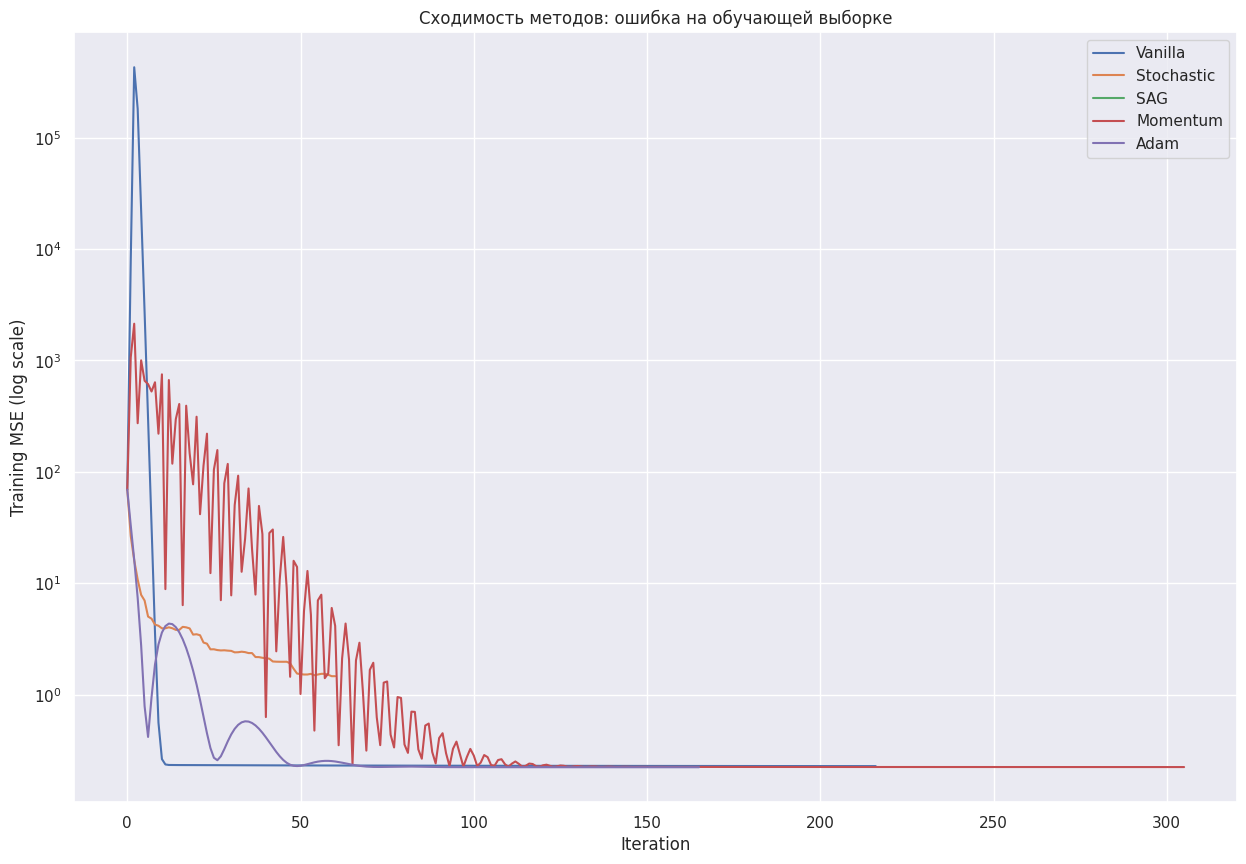

In [159]:
best_lambdas = {
    'Vanilla': 1.778279,
    'Stochastic': 0.056234,
    'SAG': 1.539927,
    'Momentum': 0.749894,
    'Adam': 0.421697
}
methods = {
    'Vanilla': VanillaGradientDescent,
    'Stochastic': StochasticGradientDescent,
    'SAG': SAGDescent,
    'Momentum': MomentumDescent,
    'Adam': Adam
}
loss_history = {}
for method_name, method in methods.items():
    opt = method(lr_schedule=lambda: TimeDecayLR(lambda_=best_lambdas[method_name]))
    if name == 'SAG':
        model = LinearRegression(optimizer=opt, tolerance=1e-12)
    else:
        model = LinearRegression(optimizer=opt)
    model.fit(x_train, y_train)
    loss_history[method_name] = model.loss_history
plt.figure(figsize=(15, 10))
for name, losses in loss_history.items():
    arr = np.array(losses)
    arr = arr[np.isfinite(arr)]
    arr = arr[arr < 1e6]
    if len(arr) > 0:
        plt.plot(range(len(arr)), arr, label=name)
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Training MSE (log scale)")
plt.title("Сходимость методов: ошибка на обучающей выборке")
plt.legend()
plt.grid(True)
plt.show()


Adam сходится доаольно плавно и среди тех, кто показал хорошее значение R^2 самый быстрый

Momentum уступает в скорости, сходится более рвано, сильно колеблется

Stochastic спускается медленнее, сильные шумы, хуже качество, скорее всего не подобрал размер батча правильно или слишком быстрые затухания

SAG не сошелся, не получилось подобрать гиперпараметры

Vanilla сошелся быстрее Momentum'а вероятно из-за большого начального лямбда, MSE поэтому поначалу сильно выырос по сравнению с остальными.

Оптимальным по качеству и скорости является Adam

## Задание 6. Стохастический градиентный спуск и размер батча (1 балл)

В этом задании вам предстоит исследовать влияние размера батча на работу стохастического градиентного спуска.

* Сделайте по несколько запусков (например, $k = 10$) стохастического градиентного спуска на обучающей выборке для каждого размера батча из перебираемого списка. Замерьте время в секундах и количество итераций до сходимости. Посчитайте среднее этих значений для каждого размера батча.
* Постройте график зависимости количества шагов до сходимости от размера батча. _(под сходимостью понимается достижение критерия останова)_
* Постройте график зависимости времени до сходимости от размера батча.

Посмотрите на получившиеся результаты. Какие выводы можно сделать про подбор размера батча для стохастического градиентного спуска?

In [160]:
import time
sgd_lambda = 0.056234
batch_sizes = [1, 8, 32, 64, 128, 256, 512, 1024]
k = 10
def sgd(batch_size:int, lam:float):
    opt = StochasticGradientDescent(lr_schedule=lambda: TimeDecayLR(lambda_=lam), batch_size=batch_size)
    model = LinearRegression(optimizer=opt)
    t0 = time.perf_counter()
    model.fit(x_train, y_train)
    dt = time.perf_counter() - t0
    iters = len(model.loss_history)
    mse = model.loss_history[-1]
    return iters, dt, mse

rows = []
for bs in batch_sizes:
    iters_, time_, mse_ = [], [], []
    for r in range(k):
        np.random.seed(None)
        iters, dt, mse = sgd(bs, sgd_lambda)
        iters_.append(iters)
        time_.append(dt)
        mse_.append(mse)

    rows.append({
        "batch_size": bs,
        "iters_mean":  float(np.mean(iters_)),
        "time_mean_s": float(np.mean(time_)),
        "final_train_mse_mean": float(np.mean(mse_))
    })

df_sgd = pd.DataFrame(rows)
display(df_sgd)


,batch_size,iters_mean,time_mean_s,final_train_mse_mean
0,1,58.8,0.651089,1.382327
1,8,457.5,6.719928,0.407975
2,32,356.7,5.469941,0.431043
3,64,354.5,5.035028,0.432002
4,128,327.0,4.957459,0.435880
5,256,313.3,4.521897,0.441638
6,512,301.7,4.357356,0.446504
7,1024,292.9,4.422677,0.446557


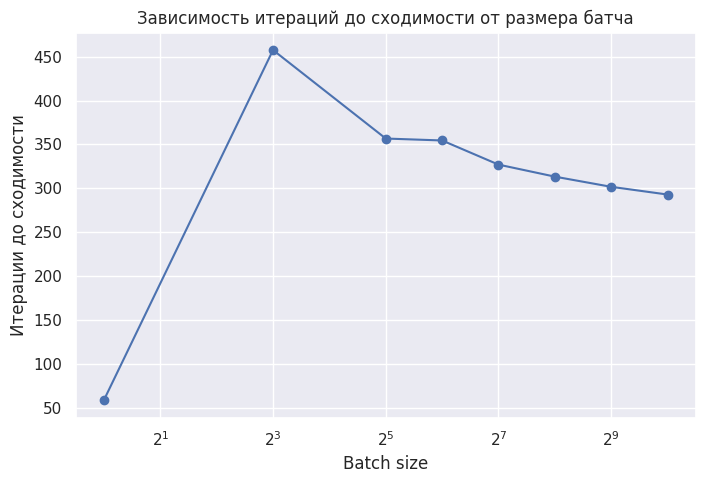

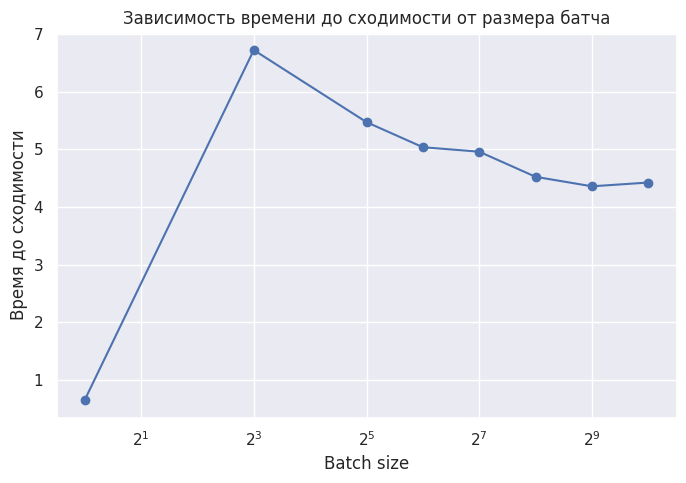

In [162]:
plt.figure(figsize=(8,5))
plt.plot(df_sgd["batch_size"], df_sgd["iters_mean"], marker='o')
plt.xscale('log', base=2)
plt.xlabel("Batch size")
plt.ylabel("Итерации до сходимости")
plt.title("Зависимость итераций до сходимости от размера батча")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(df_sgd["batch_size"], df_sgd["time_mean_s"], marker='o')
plt.xscale('log', base=2)
plt.xlabel("Batch size")
plt.ylabel("Время до сходимости")
plt.title("Зависимость времени до сходимости от размера батча")
plt.grid(True)
plt.show()


**Выводы:**

По-хорошему ожидал по логике увидеть сначала резкий скачок от сильно малого батча, а потом что-то по типу сначала батч маленький но итераций много, времени тоже, потом сходится к оптимуму по времени, и когда батч становится большим время снова начинает рости, тк на одну итерацию тратится слишком много. Но такого у меня не видно, если судить по графику то делаем батч большим и все здорово. Возможно недостаточно большие значения взял.